# Avivo Predictive Model for Completion Rate (using Admission data 2007-2017)

### Loading libraries

In [323]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import pandas_profiling

### Loading in the data and taking a first look at it: 

In [324]:
Adm_Data = pd.read_csv('C:/Users/prabl/Documents/Star82/Data/Final Datasets/merged_adm_2017_dups_removed_all_columns_30permissing.csv')
Adm_Data.head()

,Client.Number,Form.Date,Are.any.children.living.with.someone.else.due.to.CPS.court.order.or.other.action,CHSR.Dimension.2,CHSR.Dimension.3,CHSR.Dimension.4,CHSR.Dimension.5,CHSR.Dimension.6,Client.currently.involved.with.CPS,Current.CD.Treatment,...,Number.of.days..in.past.30.days..has.client.used.alcohol..99.unknown.,Number.of.days..in.past.30.days..has.client.used.illicit.drugs..99.unknown.,Number.of.lifetime.detoxification.admissions,Primary.substance.abuse.problem,Secondary.substance.abuse.problem,Tertiary.substance.abuse.problem,Where.has.client.been.living.in.past.30.days,Client.Gender,Client.Race,Reason.for.Discharge
0,111156570,0014-11-20,Not applicable - No children/no child protect ...,Minor problem,Moderate problem,Moderate problem,Serious problem,Extreme problem,Not applicable - No children,"Residential, more than 30 days planned",...,0.0,0.0,0.0,Marijuana/Hashish,No secondary or tertiary substance,No secondary or tertiary substance,Homless - no fixed address (includes shelters),Male,White,Completed program
1,111156740,0014-12-09,Not applicable - No children/no child protect ...,No problem,Moderate problem,Serious problem,Serious problem,Extreme problem,No,"Residential, more than 30 days planned",...,1.0,1.0,3.0,Other Opiates/Synthetics,Marijuana/Hashish,No secondary or tertiary substance,Homless - no fixed address (includes shelters),Male,White,Assessed as inappropriate
2,111156556,0014-11-20,Not applicable - No children/no child protect ...,No problem,Minor problem,Moderate problem,Serious problem,Serious problem,Not applicable - No children,Non-residential,...,0.0,15.0,0.0,Heroin,Methamphetamine,No secondary or tertiary substance,Homless - no fixed address (includes shelters),Male,White,NaN
3,111156559,0014-11-14,Not applicable - No children/no child protect ...,Serious problem,Serious problem,Serious problem,Extreme problem,Serious problem,Not applicable - No children,Non-residential,...,0.0,0.0,0.0,Methamphetamine,Alcohol,Marijuana/Hashish,Dependent living - dependent children and/or a...,Female,White,Completed program
4,111156639,0014-11-12,Not applicable - No children/no child protect ...,No problem,Moderate problem,Minor problem,Minor problem,Moderate problem,No,Non-residential,...,1.0,2.0,2.0,Methamphetamine,Alcohol,Nicotine/Tobacco (May not be primary),Dependent living - dependent children and/or a...,Female,NaN,NaN


In [325]:
#Capitalizing the first letter of all columns
Adm_Data.columns = [col.title() for col in Adm_Data.columns]

#Sorting the column alphabteically
Adm_Data.sort_index(axis=1, inplace = True)

In [326]:
Adm_Data.dtypes

Are.Any.Children.Living.With.Someone.Else.Due.To.Cps.Court.Order.Or.Other.Action     object
Chsr.Dimension.2                                                                     object
Chsr.Dimension.3                                                                     object
Chsr.Dimension.4                                                                     object
Chsr.Dimension.5                                                                     object
Chsr.Dimension.6                                                                     object
Client.Currently.Involved.With.Cps                                                   object
Client.Gender                                                                        object
Client.Number                                                                        object
Client.Race                                                                          object
Current.Cd.Treatment                                                            

We now create a column 'Completed' that indicates program completion - 1 or not - 0

In [327]:
#Let us first look at the levels of Reason For Discharge
Adm_Data['Reason.For.Discharge'].unique()

array(['Completed program ', 'Assessed as inappropriate ', nan,
       'Patient left without staff approval ',
       'Patient conduct (behavioral) ', 'Transferred to other program ',
       'Incarcerated ', 'Death ', 'Other ', 'Lost financial support ',
       'Completed program', 'Assessed as inappropriate', 'Patient left',
       'Transferred', 'Staff requested', 'Death', 'Incarcerated', 'Other'], dtype=object)

We notice that there are some inconsistencies in these catrgories, let's clean this up:

In [328]:
#Removing the extra spaces after the category names
Adm_Data['Reason.For.Discharge'] = [str(val).strip() for val in Adm_Data['Reason.For.Discharge']]

#converting back from string
Adm_Data.loc[Adm_Data['Reason.For.Discharge'] == 'nan', 'Reason.For.Discharge'] = np.nan
Adm_Data['Reason.For.Discharge'].unique()

array(['Completed program', 'Assessed as inappropriate', nan,
       'Patient left without staff approval',
       'Patient conduct (behavioral)', 'Transferred to other program',
       'Incarcerated', 'Death', 'Other', 'Lost financial support',
       'Patient left', 'Transferred', 'Staff requested'], dtype=object)

We still see that Patient left and Patient left without staff approval are the same thing. Similarly, Transferred and transferred to other program is the same thing.

In [329]:
Adm_Data.loc[Adm_Data['Reason.For.Discharge'] == 'Patient left', 'Reason.For.Discharge'] =  'Patient left without staff approval'
Adm_Data.loc[Adm_Data['Reason.For.Discharge'] == 'Transferred', 'Reason.For.Discharge'] =  'Transferred to other program'

Adm_Data['Reason.For.Discharge'].unique()

array(['Completed program', 'Assessed as inappropriate', nan,
       'Patient left without staff approval',
       'Patient conduct (behavioral)', 'Transferred to other program',
       'Incarcerated', 'Death', 'Other', 'Lost financial support',
       'Staff requested'], dtype=object)

In [330]:
#Creating a new comlumn for completed and not completed
Adm_Data = Adm_Data.assign(Completed = None)
for (index,row) in Adm_Data.iterrows():
    if (Adm_Data.loc[index,'Reason.For.Discharge'] == 'Completed program') or (Adm_Data.loc[index,'Reason.For.Discharge'] == 'Transferred to other program'):
        Adm_Data.loc[index,'Completed'] = 1
    else:
        Adm_Data.loc[index,'Completed'] = 0
        
Adm_Data['Completed'] = Adm_Data['Completed'].astype(int)
Adm_Data['Completed'].unique()

array([1, 0], dtype=int64)

Let's look at the data types of the columns we have

Form.Date must be of type Date, Number of arrests must be Numeric and so on. Let's fix these:

In [331]:
#Form.Date column
count = Adm_Data['Form.Date'].isnull().sum()

#percent of null values in Date
print('Percentage missing: ', count/Adm_Data.shape[0]*100)

Percentage missing:  56.8605622043


In [332]:
# We can drop this column
Adm_Data.drop('Form.Date', axis = 1, inplace = True)

In [333]:
#Taking a look at number of arrests in past 30 days:
Adm_Data['Number.Of.Arrests.In.Past.30.Days'].unique()

array(['0', '1', nan, 'no', '13', '2', '3', '12', '7', '5', '4', '30', '25'], dtype=object)

In [334]:
#Replacing 'no' with 0 and converting to numeric
Adm_Data.loc[Adm_Data['Number.Of.Arrests.In.Past.30.Days'] == 'no', 'Number.Of.Arrests.In.Past.30.Days'] = '0'

Adm_Data['Number.Of.Arrests.In.Past.30.Days'] = pd.to_numeric(Adm_Data['Number.Of.Arrests.In.Past.30.Days'])
Adm_Data['Number.Of.Arrests.In.Past.30.Days'].unique()

array([  0.,   1.,  nan,  13.,   2.,   3.,  12.,   7.,   5.,   4.,  30.,
        25.])

In [335]:
#number of days used in the past tertiary
print(Adm_Data['Number.Of.Days.Used.In.Past.30..Tertiary.'].unique())
print(Adm_Data['Number.Of.Days.Used.In.Past.30..Tertiary.'].value_counts())

['0' '15' '30' '10' nan '1' '2' 'na' '14' '5' '4' '26' '6' '13' '7' '28'
 '20' '3-Feb' '3' '12' '27' '8' '16' '9' '21' '25' '24' '17' '18' '29' '32'
 '22' '98' '11' '19']
98       1406
30        518
0         478
1          85
2          64
3          51
15         42
5          33
10         32
20         28
4          23
24         21
8          21
7          16
25         12
6          11
14         10
12          8
27          7
28          6
16          5
21          4
9           3
26          3
29          3
18          2
22          2
13          2
na          2
32          1
19          1
17          1
3-Feb       1
11          1
Name: Number.Of.Days.Used.In.Past.30..Tertiary., dtype: int64


We see that there is one entry with 3-Feb, Lets replace this with NaN. Further we also see a lot of entries have the value 98 - This most probably means it is unknown - replacing this with NaN.

In [336]:
Adm_Data.loc[Adm_Data['Number.Of.Days.Used.In.Past.30..Tertiary.'] == '3-Feb' , 
             'Number.Of.Days.Used.In.Past.30..Tertiary.'] = np.nan

Adm_Data.loc[Adm_Data['Number.Of.Days.Used.In.Past.30..Tertiary.'] == '98' , 
             'Number.Of.Days.Used.In.Past.30..Tertiary.'] = np.nan

Adm_Data.loc[Adm_Data['Number.Of.Days.Used.In.Past.30..Tertiary.'] == 'na' , 
             'Number.Of.Days.Used.In.Past.30..Tertiary.'] = np.nan

Adm_Data['Number.Of.Days.Used.In.Past.30..Tertiary.'] = pd.to_numeric(Adm_Data['Number.Of.Days.Used.In.Past.30..Tertiary.']) 
print(Adm_Data['Number.Of.Days.Used.In.Past.30..Tertiary.'].unique())

[  0.  15.  30.  10.  nan   1.   2.  14.   5.   4.  26.   6.  13.   7.  28.
  20.   3.  12.  27.   8.  16.   9.  21.  25.  24.  17.  18.  29.  32.  22.
  11.  19.]


In [337]:
#Let's count the number of unknown values:
Adm_Data['Number.Of.Days.Used.In.Past.30..Tertiary.'].isnull().sum()

2099

In [338]:
#Dropping this column because of excessive NA columns
Adm_Data.drop('Number.Of.Days.Used.In.Past.30..Tertiary.',axis=1, inplace = True)

In [339]:
Adm_Data.dtypes

Are.Any.Children.Living.With.Someone.Else.Due.To.Cps.Court.Order.Or.Other.Action     object
Chsr.Dimension.2                                                                     object
Chsr.Dimension.3                                                                     object
Chsr.Dimension.4                                                                     object
Chsr.Dimension.5                                                                     object
Chsr.Dimension.6                                                                     object
Client.Currently.Involved.With.Cps                                                   object
Client.Gender                                                                        object
Client.Number                                                                        object
Client.Race                                                                          object
Current.Cd.Treatment                                                            

In [340]:
pandas_profiling.ProfileReport(Adm_Data)

Number of variables,29
Number of observations,3593
Total Missing (%),3.7%
Total size in memory,800.1 KiB
Average record size in memory,228.0 B
Numeric,7
Categorical,21
Date,0
Text (Unique),1
Rejected,0
Distinct count,5


In [341]:
# Let's look at the first column
Adm_Data['Are.Any.Children.Living.With.Someone.Else.Due.To.Cps.Court.Order.Or.Other.Action'].unique()

array(['Not applicable - No children/no child protect involvement', nan,
       'Yes', 'No', 'Not applicable'], dtype=object)

We can see that Not applicable is repeated.

In [342]:
Adm_Data.loc[Adm_Data['Are.Any.Children.Living.With.Someone.Else.Due.To.Cps.Court.Order.Or.Other.Action'] == 'Not applicable' ,
             'Are.Any.Children.Living.With.Someone.Else.Due.To.Cps.Court.Order.Or.Other.Action'] = 'Not applicable - No children/no child protect involvement'

Adm_Data['Are.Any.Children.Living.With.Someone.Else.Due.To.Cps.Court.Order.Or.Other.Action'].unique()

array(['Not applicable - No children/no child protect involvement', nan,
       'Yes', 'No'], dtype=object)

Looking at the CHSR Dimensions

Again, here we notice that Minor and Minor Problem are the same thing

In [343]:
Adm_Data['Chsr.Dimension.2'].unique()

array(['Minor problem', 'No problem', 'Serious problem',
       'Moderate problem', 'Unable to Assess', 'Moderate', nan, 'Minor',
       'Serious', 'Extreme'], dtype=object)

In [344]:
Adm_Data.loc[Adm_Data['Chsr.Dimension.2'] == 'Minor' ,
             'Chsr.Dimension.2'] = 'Minor problem'

Adm_Data.loc[Adm_Data['Chsr.Dimension.2'] == 'Moderate' ,
             'Chsr.Dimension.2'] = 'Moderate problem'

Adm_Data.loc[Adm_Data['Chsr.Dimension.2'] == 'Serious' ,
             'Chsr.Dimension.2'] = 'Serious problem'

Adm_Data.loc[Adm_Data['Chsr.Dimension.2'] == 'Extreme' ,
             'Chsr.Dimension.2'] = 'Extreme problem'

Adm_Data['Chsr.Dimension.2'].unique()

array(['Minor problem', 'No problem', 'Serious problem',
       'Moderate problem', 'Unable to Assess', nan, 'Extreme problem'], dtype=object)

In [345]:
Adm_Data['Chsr.Dimension.3'].unique()

array(['Moderate problem', 'Minor problem', 'Serious problem',
       'No problem', 'Unable to assess', 'Moderate', 'Serious', nan,
       'Minor', 'Extreme'], dtype=object)

In [346]:
Adm_Data.loc[Adm_Data['Chsr.Dimension.3'] == 'Minor' ,
             'Chsr.Dimension.3'] = 'Minor problem'

Adm_Data.loc[Adm_Data['Chsr.Dimension.3'] == 'Moderate' ,
             'Chsr.Dimension.3'] = 'Moderate problem'

Adm_Data.loc[Adm_Data['Chsr.Dimension.3'] == 'Serious' ,
             'Chsr.Dimension.3'] = 'Serious problem'

Adm_Data.loc[Adm_Data['Chsr.Dimension.3'] == 'Extreme' ,
             'Chsr.Dimension.3'] = 'Extreme problem'

Adm_Data['Chsr.Dimension.3'].unique()

array(['Moderate problem', 'Minor problem', 'Serious problem',
       'No problem', 'Unable to assess', nan, 'Extreme problem'], dtype=object)

In [347]:
Adm_Data['Chsr.Dimension.4'].unique()

array(['Moderate problem', 'Serious problem', 'Minor problem',
       'No problem', 'Extreme problem', 'Unable to assess', 'Serious',
       'Moderate', 'Minor', nan, 'Extreme'], dtype=object)

In [348]:
Adm_Data.loc[Adm_Data['Chsr.Dimension.4'] == 'Minor' ,
             'Chsr.Dimension.4'] = 'Minor problem'

Adm_Data.loc[Adm_Data['Chsr.Dimension.4'] == 'Moderate' ,
             'Chsr.Dimension.4'] = 'Moderate problem'

Adm_Data.loc[Adm_Data['Chsr.Dimension.4'] == 'Serious' ,
             'Chsr.Dimension.4'] = 'Serious problem'

Adm_Data.loc[Adm_Data['Chsr.Dimension.4'] == 'Extreme' ,
             'Chsr.Dimension.4'] = 'Extreme problem'

Adm_Data['Chsr.Dimension.4'].unique()

array(['Moderate problem', 'Serious problem', 'Minor problem',
       'No problem', 'Extreme problem', 'Unable to assess', nan], dtype=object)

In [349]:
Adm_Data['Chsr.Dimension.5'].unique()

array(['Serious problem', 'Extreme problem', 'Minor problem',
       'Moderate problem', 'Unable to assess', 'No problem', 'Moderate',
       'Serious', 'Extreme', nan, 'Minor'], dtype=object)

In [350]:
Adm_Data.loc[Adm_Data['Chsr.Dimension.5'] == 'Minor' ,
             'Chsr.Dimension.5'] = 'Minor problem'

Adm_Data.loc[Adm_Data['Chsr.Dimension.5'] == 'Moderate' ,
             'Chsr.Dimension.5'] = 'Moderate problem'

Adm_Data.loc[Adm_Data['Chsr.Dimension.5'] == 'Serious' ,
             'Chsr.Dimension.5'] = 'Serious problem'

Adm_Data.loc[Adm_Data['Chsr.Dimension.5'] == 'Extreme' ,
             'Chsr.Dimension.5'] = 'Extreme problem'

Adm_Data['Chsr.Dimension.5'].unique()

array(['Serious problem', 'Extreme problem', 'Minor problem',
       'Moderate problem', 'Unable to assess', 'No problem', nan], dtype=object)

In [351]:
Adm_Data['Chsr.Dimension.6'].unique()

array(['Extreme problem', 'Serious problem', 'Moderate problem',
       'Minor problem', 'Unable to assess', 'No problem', 'Serious',
       'Moderate', 'Extreme', nan, 'Minor'], dtype=object)

In [352]:
Adm_Data.loc[Adm_Data['Chsr.Dimension.6'] == 'Minor' ,
             'Chsr.Dimension.6'] = 'Minor problem'

Adm_Data.loc[Adm_Data['Chsr.Dimension.6'] == 'Moderate' ,
             'Chsr.Dimension.6'] = 'Moderate problem'

Adm_Data.loc[Adm_Data['Chsr.Dimension.6'] == 'Serious' ,
             'Chsr.Dimension.6'] = 'Serious problem'

Adm_Data.loc[Adm_Data['Chsr.Dimension.6'] == 'Extreme' ,
             'Chsr.Dimension.6'] = 'Extreme problem'

Adm_Data['Chsr.Dimension.6'].unique()

array(['Extreme problem', 'Serious problem', 'Moderate problem',
       'Minor problem', 'Unable to assess', 'No problem', nan], dtype=object)

Looking at CPS involvement

In [353]:
Adm_Data['Client.Currently.Involved.With.Cps'].unique()

array(['Not applicable - No children', 'No', 'Yes', nan, 'Not applicable'], dtype=object)

In [354]:
Adm_Data.loc[Adm_Data['Client.Currently.Involved.With.Cps'] == 'Not applicable' ,
             'Client.Currently.Involved.With.Cps'] = 'Not applicable - No children'

Adm_Data['Client.Currently.Involved.With.Cps'].unique()

array(['Not applicable - No children', 'No', 'Yes', nan], dtype=object)

Client Number will not add any power to our predictive model as it is just an identifier. We can drop this:

In [355]:
Adm_Data.drop('Client.Number', axis=1, inplace=True)

Looking at current CD Treatment:

In [356]:
Adm_Data['Current.Cd.Treatment'].unique()

array(['Residential, more than 30 days planned', 'Non-residential',
       'Methadone clinic', 'Hospital inpatient',
       'Residential, less than 30 days planned', 'Non-Residential',
       'Long-term Residential'], dtype=object)

In [357]:
Adm_Data.loc[Adm_Data['Current.Cd.Treatment'] == 'Non-residential' ,
             'Current.Cd.Treatment'] = 'Non-Residential'

Adm_Data['Current.Cd.Treatment'].unique()

array(['Residential, more than 30 days planned', 'Non-Residential',
       'Methadone clinic', 'Hospital inpatient',
       'Residential, less than 30 days planned', 'Long-term Residential'], dtype=object)

In [358]:
#Labor Status
Adm_Data['Current.Labor.Status'].unique()

array([nan, 'Laid off/unemployed - not looking for work', 'Disabled',
       'Other', 'Laid off/unemployed - looking for work',
       'Employed full-time (>= 35 hours/week)',
       'Employed part-time (< 35 hours/week)', 'Retired',
       'Inmate of institution', 'Occassional/seasonal work', 'Student',
       'Homemaker', 'Unemployed - not looking', 'Unemployed - looking',
       'Full-time', 'Occasional', 'Part-time', 'Inmate'], dtype=object)

In [359]:
Adm_Data.loc[Adm_Data['Current.Labor.Status'] == 'Inmate' ,
             'Current.Labor.Status'] = 'Inmate of institution'

Adm_Data.loc[Adm_Data['Current.Labor.Status'] == 'Full-time' ,
             'Current.Labor.Status'] = 'Employed full-time (>= 35 hours/week)'

Adm_Data.loc[Adm_Data['Current.Labor.Status'] == 'Part-time' ,
             'Current.Labor.Status'] = 'Employed part-time (< 35 hours/week)'

Adm_Data.loc[Adm_Data['Current.Labor.Status'] == 'Occasional' ,
             'Current.Labor.Status'] = 'Occassional/seasonal work'

Adm_Data.loc[Adm_Data['Current.Labor.Status'] == 'Unemployed - not looking' ,
             'Current.Labor.Status'] = 'Laid off/unemployed - not looking for work'

Adm_Data.loc[Adm_Data['Current.Labor.Status'] == 'Unemployed - looking' ,
             'Current.Labor.Status'] = 'Laid off/unemployed - looking for work'

Adm_Data['Current.Labor.Status'].unique()

array([nan, 'Laid off/unemployed - not looking for work', 'Disabled',
       'Other', 'Laid off/unemployed - looking for work',
       'Employed full-time (>= 35 hours/week)',
       'Employed part-time (< 35 hours/week)', 'Retired',
       'Inmate of institution', 'Occassional/seasonal work', 'Student',
       'Homemaker'], dtype=object)

Looking at the Parental Rights column

In [360]:
Adm_Data['For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'].unique()

array(['No children/no child protection involvement', nan, 'Three', 'Six',
       'One', 'Two', 'Five', 'Four', 'Ten or more', '0', '3', '2', '1',
       '5', '4', '8', '7'], dtype=object)

In [361]:
Adm_Data.loc[Adm_Data['For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'] == 'One' ,
             'For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'] = '1'

Adm_Data.loc[Adm_Data['For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'] == 'Two' ,
             'For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'] = '2'

Adm_Data.loc[Adm_Data['For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'] == 'Three' ,
             'For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'] = '3'

Adm_Data.loc[Adm_Data['For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'] == 'Four' ,
             'For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'] = '4'

Adm_Data.loc[Adm_Data['For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'] == 'Five' ,
             'For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'] = '5'

Adm_Data.loc[Adm_Data['For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'] == 'Six' ,
             'For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'] = '6'

Adm_Data.loc[Adm_Data['For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'] == 'Ten or more' ,
             'For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'] = '10'

Adm_Data.loc[Adm_Data['For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'] == 'No children/no child protection involvement' ,
             'For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'] = '0'

#Adm_Data['For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'] = pd.to_numeric(Adm_Data['For.How.Many.Children.Has.The.Client.Lost.Parental.Rights']) 
Adm_Data['For.How.Many.Children.Has.The.Client.Lost.Parental.Rights'].unique()

array(['0', nan, '3', '6', '1', '2', '5', '4', '10', '8', '7'], dtype=object)

Looking at number of Days used in the past Secondary:

In [362]:
Adm_Data['Number.Of.Days.Used.In.Past.30..Secondary.'].unique()

array([  0.,  10.,   1.,   3.,   2.,   5.,  15.,  nan,  30.,  20.,  18.,
         4.,  12.,  21.,   7.,  19.,  28.,  23.,  24.,  26.,  25.,  13.,
        22.,  14.,   8.,   6.,  27.,  29.,   9.,  16.,  11.,  98.,  17.])

In [363]:
Adm_Data.loc[Adm_Data['Number.Of.Days.Used.In.Past.30..Secondary.'] == 98 ,
             'Number.Of.Days.Used.In.Past.30..Secondary.'] = np.nan

Adm_Data['Number.Of.Days.Used.In.Past.30..Secondary.'].unique()

array([  0.,  10.,   1.,   3.,   2.,   5.,  15.,  nan,  30.,  20.,  18.,
         4.,  12.,  21.,   7.,  19.,  28.,  23.,  24.,  26.,  25.,  13.,
        22.,  14.,   8.,   6.,  27.,  29.,   9.,  16.,  11.,  17.])

Looking at Primary substance abuse problem:

In [364]:
list(Adm_Data['Primary.Substance.Abuse.Problem'].unique())

['Marijuana/Hashish',
 'Other Opiates/Synthetics',
 'Heroin',
 'Methamphetamine',
 'Alcohol',
 'Ecstasy/other club drugs',
 'Crack',
 'Benzodiazepines',
 'PCP',
 'Cocaine power',
 'Other Stimulants',
 'Over-The-Counter Medications',
 'Non-prescription Methadone',
 'Other Sedative/Hypnotic/Anxiolytic',
 'Cocaine powder',
 'Other Hallucinogens/Psychedelics',
 'Other',
 'Marijuana-Hashish',
 'Cocaine',
 'Inhalants',
 nan,
 'Other Amphetamines']

In [365]:
Adm_Data.loc[Adm_Data['Primary.Substance.Abuse.Problem'] == 'Marijuana-Hashish' ,
             'Primary.Substance.Abuse.Problem'] = 'Marijuana/Hashish'

Adm_Data.loc[Adm_Data['Primary.Substance.Abuse.Problem'] == 'Cocaine power' ,
             'Primary.Substance.Abuse.Problem'] = 'Cocaine powder'

Adm_Data.loc[Adm_Data['Primary.Substance.Abuse.Problem'] == 'Cocaine' ,
             'Primary.Substance.Abuse.Problem'] = 'Cocaine powder'


list(Adm_Data['Primary.Substance.Abuse.Problem'].unique())

['Marijuana/Hashish',
 'Other Opiates/Synthetics',
 'Heroin',
 'Methamphetamine',
 'Alcohol',
 'Ecstasy/other club drugs',
 'Crack',
 'Benzodiazepines',
 'PCP',
 'Cocaine powder',
 'Other Stimulants',
 'Over-The-Counter Medications',
 'Non-prescription Methadone',
 'Other Sedative/Hypnotic/Anxiolytic',
 'Other Hallucinogens/Psychedelics',
 'Other',
 'Inhalants',
 nan,
 'Other Amphetamines']

In [366]:
list(Adm_Data['Secondary.Substance.Abuse.Problem'].unique())

['No secondary or tertiary substance',
 'Marijuana/Hashish',
 'Methamphetamine',
 'Alcohol',
 'Other Opiates/Synthetics',
 'Heroin',
 'Crack',
 'Nicotine/Tobacco (May not be primary)',
 'Cocaine power',
 'Benzodiazepines',
 nan,
 'Other Hallucinogens/Psychedelics',
 'Ketamine',
 'Non-prescription Methadone',
 'Other Amphetamines',
 'Cocaine powder',
 'Over-The-Counter Medications',
 'Other',
 'Ecstasy/other club drugs',
 'No secondary substance',
 'Marijuana-Hashish',
 'Cocaine',
 'Nicotine/Tobacco',
 'PCP',
 'Barbiturates',
 'Other Tranquilizers']

In [367]:
Adm_Data.loc[Adm_Data['Secondary.Substance.Abuse.Problem'] == 'Marijuana-Hashish' ,
             'Secondary.Substance.Abuse.Problem'] = 'Marijuana/Hashish'

Adm_Data.loc[Adm_Data['Secondary.Substance.Abuse.Problem'] == 'Cocaine power' ,
             'Secondary.Substance.Abuse.Problem'] = 'Cocaine powder'

Adm_Data.loc[Adm_Data['Secondary.Substance.Abuse.Problem'] == 'Cocaine' ,
             'Secondary.Substance.Abuse.Problem'] = 'Cocaine powder'

Adm_Data.loc[Adm_Data['Secondary.Substance.Abuse.Problem'] == 'Nicotine/Tobacco (May not be primary)r' ,
             'Secondary.Substance.Abuse.Problem'] = 'Nicotine/Tobacco'

Adm_Data.loc[Adm_Data['Secondary.Substance.Abuse.Problem'] == 'No secondary substance' ,
             'Secondary.Substance.Abuse.Problem'] = np.nan

Adm_Data.loc[Adm_Data['Secondary.Substance.Abuse.Problem'] == 'No secondary or tertiary substance' ,
             'Secondary.Substance.Abuse.Problem'] = np.nan

list(Adm_Data['Secondary.Substance.Abuse.Problem'].unique())

[nan,
 'Marijuana/Hashish',
 'Methamphetamine',
 'Alcohol',
 'Other Opiates/Synthetics',
 'Heroin',
 'Crack',
 'Nicotine/Tobacco (May not be primary)',
 'Cocaine powder',
 'Benzodiazepines',
 'Other Hallucinogens/Psychedelics',
 'Ketamine',
 'Non-prescription Methadone',
 'Other Amphetamines',
 'Over-The-Counter Medications',
 'Other',
 'Ecstasy/other club drugs',
 'Nicotine/Tobacco',
 'PCP',
 'Barbiturates',
 'Other Tranquilizers']

In [368]:
list(Adm_Data['Tertiary.Substance.Abuse.Problem'].unique())

['No secondary or tertiary substance',
 'Marijuana/Hashish',
 'Nicotine/Tobacco (May not be primary)',
 'Crack',
 'Other Opiates/Synthetics',
 'Heroin',
 'Cocaine power',
 'Methamphetamine',
 'Alcohol',
 'Other Hallucinogens/Psychedelics',
 nan,
 'Other Stimulants',
 'Other',
 'Benzodiazepines',
 'Cocaine powder',
 'Ecstasy/other club drugs',
 'Other Amphetamines',
 'Non-prescription Methadone',
 'Marijuana-Hashish',
 'Cocaine',
 'No tertiary substance',
 'Nicotine/Tobacco',
 'Inhalants',
 'Over-The-Counter Medications',
 'Other Sedative/Hypnotic/Anxiolytic',
 'PCP',
 'Barbiturates']

In [369]:
Adm_Data.loc[Adm_Data['Tertiary.Substance.Abuse.Problem'] == 'Marijuana-Hashish' ,
             'Tertiary.Substance.Abuse.Problem'] = 'Marijuana/Hashish'

Adm_Data.loc[Adm_Data['Tertiary.Substance.Abuse.Problem'] == 'Cocaine power' ,
             'Tertiary.Substance.Abuse.Problem'] = 'Cocaine powder'

Adm_Data.loc[Adm_Data['Tertiary.Substance.Abuse.Problem'] == 'Cocaine' ,
             'Tertiary.Substance.Abuse.Problem'] = 'Cocaine powder'

Adm_Data.loc[Adm_Data['Tertiary.Substance.Abuse.Problem'] == 'Nicotine/Tobacco (May not be primary)r' ,
             'Tertiary.Substance.Abuse.Problem'] = 'Nicotine/Tobacco'

Adm_Data.loc[Adm_Data['Tertiary.Substance.Abuse.Problem'] == 'No tertiary substance' ,
             'Tertiary.Substance.Abuse.Problem'] = np.nan

Adm_Data.loc[Adm_Data['Tertiary.Substance.Abuse.Problem'] == 'No secondary or tertiary substance' ,
             'Tertiary.Substance.Abuse.Problem'] = np.nan

list(Adm_Data['Tertiary.Substance.Abuse.Problem'].unique())

[nan,
 'Marijuana/Hashish',
 'Nicotine/Tobacco (May not be primary)',
 'Crack',
 'Other Opiates/Synthetics',
 'Heroin',
 'Cocaine powder',
 'Methamphetamine',
 'Alcohol',
 'Other Hallucinogens/Psychedelics',
 'Other Stimulants',
 'Other',
 'Benzodiazepines',
 'Ecstasy/other club drugs',
 'Other Amphetamines',
 'Non-prescription Methadone',
 'Nicotine/Tobacco',
 'Inhalants',
 'Over-The-Counter Medications',
 'Other Sedative/Hypnotic/Anxiolytic',
 'PCP',
 'Barbiturates']

Looking at Where client has been living in the past 30 days:

In [370]:
Adm_Data['Where.Has.Client.Been.Living.In.Past.30.Days'].unique()

array(['Homless - no fixed address (includes shelters)',
       'Dependent living - dependent children and/or adults living in a supervised setting',
       'Independent living - including on own, self supported and non-supervised group homes',
       'Children living with their family', nan, 'Dependent living',
       'Independent living', 'Homeless', 'Children with family'], dtype=object)

In [371]:
Adm_Data.loc[Adm_Data['Where.Has.Client.Been.Living.In.Past.30.Days'] == 'Homeless' ,
             'Where.Has.Client.Been.Living.In.Past.30.Days'] = 'Homless - no fixed address (includes shelters)'

Adm_Data.loc[Adm_Data['Where.Has.Client.Been.Living.In.Past.30.Days'] == 'Dependent living' ,
             'Where.Has.Client.Been.Living.In.Past.30.Days'] = 'Dependent living - dependent children and/or adults living in a supervised setting'

Adm_Data.loc[Adm_Data['Where.Has.Client.Been.Living.In.Past.30.Days'] == 'Independent living' ,
             'Where.Has.Client.Been.Living.In.Past.30.Days'] = 'Independent living - including on own, self supported and non-supervised group homes'

Adm_Data.loc[Adm_Data['Where.Has.Client.Been.Living.In.Past.30.Days'] == 'Children with family' ,
             'Where.Has.Client.Been.Living.In.Past.30.Days'] = 'Children living with their family'

Adm_Data['Where.Has.Client.Been.Living.In.Past.30.Days'].unique()

array(['Homless - no fixed address (includes shelters)',
       'Dependent living - dependent children and/or adults living in a supervised setting',
       'Independent living - including on own, self supported and non-supervised group homes',
       'Children living with their family', nan], dtype=object)

Looking at Client Race and splitting it into multiple columns:

In [372]:
list(Adm_Data['Client.Race'].unique())

['White',
 nan,
 'Black or African American',
 'American Indian or Alaska Native',
 'American Indian or Alaska Native\nHispanic or Latino',
 'Native Hawaiian or Other Pacific Islander',
 'White\nBlack or African American',
 'Hispanic or Latino',
 'Black or African American\nAmerican Indian or Alaska Native\nOther Race',
 'Other Race',
 'Declined to Specify',
 'Black or African American\nOther Race',
 'Black or African American\nHispanic or Latino',
 'Asian',
 'White\nNative Hawaiian or Other Pacific Islander',
 'White\nDeclined to Specify',
 'Black or African American\nDeclined to Specify',
 'White\nAmerican Indian or Alaska Native\nHispanic or Latino',
 'Black or African American\nAmerican Indian or Alaska Native',
 'White\nAmerican Indian or Alaska Native',
 'Asian\nHispanic or Latino',
 'White\nOther Race\nDeclined to Specify',
 'Asian\nDeclined to Specify',
 'White\nBlack or African American\nAmerican Indian or Alaska Native',
 'White\nHispanic or Latino',
 'White\nHispanic or Lati

In [373]:
splitFunc = lambda x: pd.Series([i for i in str(x).split('\n')])
Race = pd.DataFrame(Adm_Data['Client.Race'].apply(splitFunc))
Race.columns = ['Race1','Race2','Race3','Race4']
Adm_Data = pd.concat([Adm_Data, Race], axis = 1)
list(Adm_Data.columns)

['Are.Any.Children.Living.With.Someone.Else.Due.To.Cps.Court.Order.Or.Other.Action',
 'Chsr.Dimension.2',
 'Chsr.Dimension.3',
 'Chsr.Dimension.4',
 'Chsr.Dimension.5',
 'Chsr.Dimension.6',
 'Client.Currently.Involved.With.Cps',
 'Client.Gender',
 'Client.Race',
 'Current.Cd.Treatment',
 'Current.Labor.Status',
 'Currently.Enrolled.In.School.Or.Job.Training.Program',
 'Did.Drug.Court.Refer.',
 'Does.Client.Have.Children',
 'For.How.Many.Children.Has.The.Client.Lost.Parental.Rights',
 'Interaction.With.Supportive.Family.Friends.In.Past.30.Days',
 'Number.Of.Arrests.In.Past.30.Days',
 'Number.Of.Days..In.Past.30.Days..Has.Client.Used.Alcohol..99.Unknown.',
 'Number.Of.Days..In.Past.30.Days..Has.Client.Used.Illicit.Drugs..99.Unknown.',
 'Number.Of.Days.Used.In.Past.30..Primary.',
 'Number.Of.Days.Used.In.Past.30..Secondary.',
 'Number.Of.Lifetime.Detoxification.Admissions',
 'Primary.Substance.Abuse.Problem',
 'Reason.For.Discharge',
 'Secondary.Substance.Abuse.Problem',
 'Tertiary.Substa

We can now drop the 'Client.Race' column

In [374]:
Adm_Data.drop('Client.Race', axis=1, inplace=True)

In [375]:
Adm_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3593 entries, 0 to 3592
Data columns (total 31 columns):
Are.Any.Children.Living.With.Someone.Else.Due.To.Cps.Court.Order.Or.Other.Action    3561 non-null object
Chsr.Dimension.2                                                                    2854 non-null object
Chsr.Dimension.3                                                                    3151 non-null object
Chsr.Dimension.4                                                                    3390 non-null object
Chsr.Dimension.5                                                                    3574 non-null object
Chsr.Dimension.6                                                                    3490 non-null object
Client.Currently.Involved.With.Cps                                                  3566 non-null object
Client.Gender                                                                       3591 non-null object
Current.Cd.Treatment                                 

Looking at the number of non-null values of Race2, Race3 and Race4 we can see that they have more than 30% values missing and hence we can drop these columns

In [376]:
Adm_Data.drop(['Race2','Race3','Race4'], axis=1, inplace=True)
Adm_Data.shape

(3593, 28)

In [377]:
Adm_Data['Race1'].value_counts()

African American                             1097
Black or African American                     699
Caucasian White                               563
White                                         486
American Indian or Alaska Native              185
American Indian                               136
Multiracial                                    74
nan                                            68
Other Race                                     42
Hispanic                                       40
Native American                                37
Declined to Specify                            31
Hispanic or Latino                             27
African                                        24
Black / African American                       20
Asian                                          20
Somali                                          7
Race Unknown                                    6
Native Hawaiian or Other Pacific Islander       4
Black/African American                          3


In [378]:
Adm_Data.loc[Adm_Data['Race1'] == 'Somail', 'Race1'] = 'Somali'
Adm_Data.loc[Adm_Data['Race1'] == 'Somalian', 'Race1'] = 'Somali'
Adm_Data.loc[Adm_Data['Race1'] == 'Samalian', 'Race1'] = 'Somali'
Adm_Data.loc[Adm_Data['Race1'] == 'Africian', 'Race1'] = 'African'
Adm_Data.loc[Adm_Data['Race1'] == 'Bi- racial', 'Race1'] = 'Bi-racial'
Adm_Data.loc[Adm_Data['Race1'] == 'Black / African American', 'Race1'] = 'Black or African American'
Adm_Data.loc[Adm_Data['Race1'] == 'Black/African American', 'Race1'] = 'Black or African American'
Adm_Data.loc[Adm_Data['Race1'] == 'Does not identy', 'Race1'] = 'Does not associate'
Adm_Data.loc[Adm_Data['Race1'] == 'Deos not assiciate', 'Race1'] = 'Does not associate'
Adm_Data.loc[Adm_Data['Race1'] == 'Native Amercian', 'Race1'] = 'Native American'
Adm_Data.loc[Adm_Data['Race1'] == 'Caucasian/Native', 'Race1'] = 'Caucasian/ Native American'
Adm_Data.loc[Adm_Data['Race1'] == 'Race Unknown', 'Race1'] = np.nan
Adm_Data.loc[Adm_Data['Race1'] == 'Hispanic', 'Race1'] = 'Hispanic or Latino'

val_counts = Adm_Data['Race1'].value_counts()
val_counts = val_counts[val_counts<=4]

l1 = list(val_counts.index)
Adm_Data.loc[Adm_Data['Race1'].isin(l1), 'Race1'] = 'Other Race'

Adm_Data['Race1'].value_counts()

African American                    1097
Black or African American            722
Caucasian White                      563
White                                486
American Indian or Alaska Native     185
American Indian                      136
Multiracial                           74
nan                                   68
Hispanic or Latino                    67
Other Race                            63
Native American                       38
Declined to Specify                   31
African                               25
Asian                                 20
Somali                                12
Name: Race1, dtype: int64

In [379]:
#char_cols = Adm_Data.dtypes.pipe(lambda x: x[x == 'object']).index

#for c in char_cols:
#    Adm_Data[c] = Adm_Data[c].astype('category')

In [380]:
#Dropping Reason for Discharge
Adm_Data.drop('Reason.For.Discharge', axis=1, inplace=True)

In [381]:
Adm_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3593 entries, 0 to 3592
Data columns (total 27 columns):
Are.Any.Children.Living.With.Someone.Else.Due.To.Cps.Court.Order.Or.Other.Action    3561 non-null object
Chsr.Dimension.2                                                                    2854 non-null object
Chsr.Dimension.3                                                                    3151 non-null object
Chsr.Dimension.4                                                                    3390 non-null object
Chsr.Dimension.5                                                                    3574 non-null object
Chsr.Dimension.6                                                                    3490 non-null object
Client.Currently.Involved.With.Cps                                                  3566 non-null object
Client.Gender                                                                       3591 non-null object
Current.Cd.Treatment                                 

Converting the Categorical columns into One-hot-encoded columns:

In [382]:
#Getting the list of columns to encode
cols = list(Adm_Data.columns)
remove_cols = ['Completed', 'Number.Of.Lifetime.Detoxification.Admissions', 
             'Number.Of.Days.Used.In.Past.30..Secondary.', 'Number.Of.Days.Used.In.Past.30..Primary.',
            'Number.Of.Days..In.Past.30.Days..Has.Client.Used.Illicit.Drugs..99.Unknown.',
            'Number.Of.Days..In.Past.30.Days..Has.Client.Used.Alcohol..99.Unknown.',
            'Number.Of.Arrests.In.Past.30.Days']

cols = [c for c in cols if c not in remove_cols]
cols

['Are.Any.Children.Living.With.Someone.Else.Due.To.Cps.Court.Order.Or.Other.Action',
 'Chsr.Dimension.2',
 'Chsr.Dimension.3',
 'Chsr.Dimension.4',
 'Chsr.Dimension.5',
 'Chsr.Dimension.6',
 'Client.Currently.Involved.With.Cps',
 'Client.Gender',
 'Current.Cd.Treatment',
 'Current.Labor.Status',
 'Currently.Enrolled.In.School.Or.Job.Training.Program',
 'Did.Drug.Court.Refer.',
 'Does.Client.Have.Children',
 'For.How.Many.Children.Has.The.Client.Lost.Parental.Rights',
 'Interaction.With.Supportive.Family.Friends.In.Past.30.Days',
 'Primary.Substance.Abuse.Problem',
 'Secondary.Substance.Abuse.Problem',
 'Tertiary.Substance.Abuse.Problem',
 'Where.Has.Client.Been.Living.In.Past.30.Days',
 'Race1']

In [383]:
Adm_Data = pd.concat([pd.get_dummies(Adm_Data, columns = cols, drop_first=True)], axis = 1)
Adm_Data.shape

(3593, 146)

In [384]:
print(Adm_Data[remove_cols].isnull().sum())

Completed                                                                        0
Number.Of.Lifetime.Detoxification.Admissions                                   120
Number.Of.Days.Used.In.Past.30..Secondary.                                     991
Number.Of.Days.Used.In.Past.30..Primary.                                        95
Number.Of.Days..In.Past.30.Days..Has.Client.Used.Illicit.Drugs..99.Unknown.     49
Number.Of.Days..In.Past.30.Days..Has.Client.Used.Alcohol..99.Unknown.           47
Number.Of.Arrests.In.Past.30.Days                                               93
dtype: int64


In [385]:
#Replacing the NA's with 0
Adm_Data.replace(np.nan, -1, inplace=True)
print(Adm_Data[remove_cols].isnull().sum())

Completed                                                                      0
Number.Of.Lifetime.Detoxification.Admissions                                   0
Number.Of.Days.Used.In.Past.30..Secondary.                                     0
Number.Of.Days.Used.In.Past.30..Primary.                                       0
Number.Of.Days..In.Past.30.Days..Has.Client.Used.Illicit.Drugs..99.Unknown.    0
Number.Of.Days..In.Past.30.Days..Has.Client.Used.Alcohol..99.Unknown.          0
Number.Of.Arrests.In.Past.30.Days                                              0
dtype: int64


## Building a Decision Tree Model

In [386]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz

In [387]:
#Selecting list of inputs
inputs = list(Adm_Data.columns)
inputs.remove('Completed')
len(inputs)

145

In [388]:
# separating inputs and output
y = Adm_Data['Completed']
X = Adm_Data[inputs]

In [389]:
#Splitting data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20)

In [390]:
#Building the classifier
clf = tree.DecisionTreeClassifier(random_state=20, min_samples_split=100, min_samples_leaf=50)
clf = clf.fit(X,y)

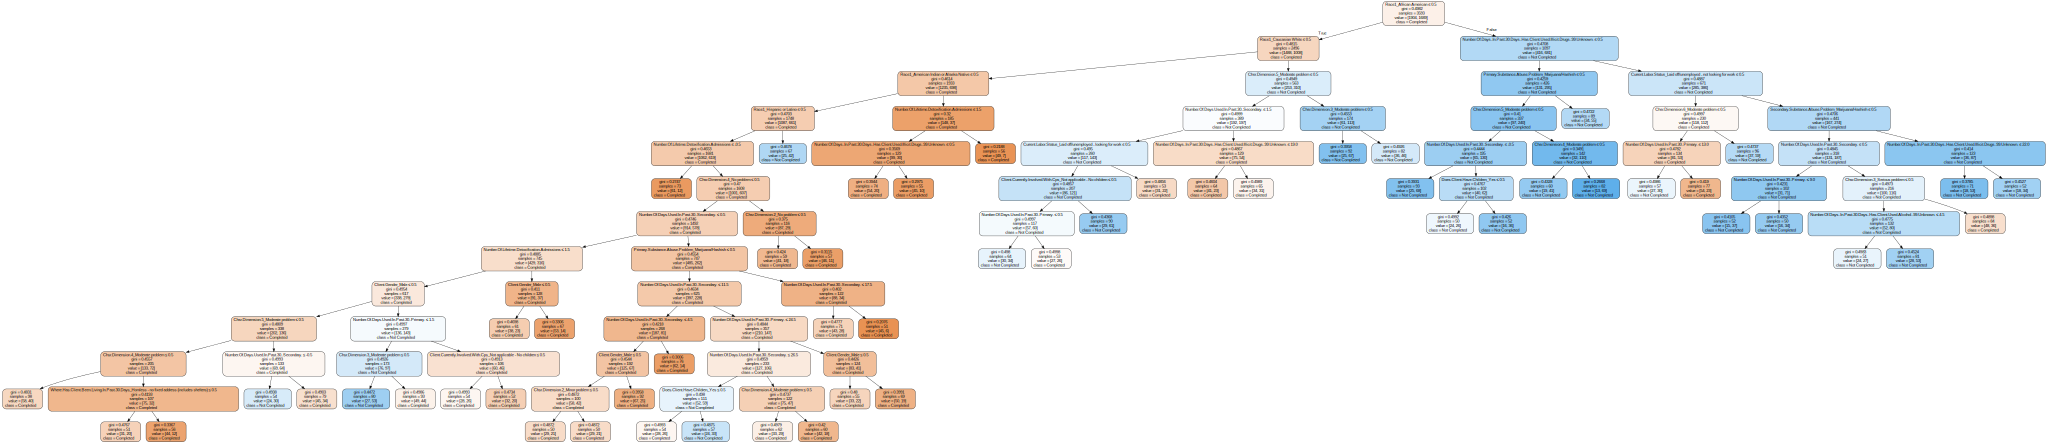

In [391]:
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=X.columns,  
                         class_names=['Completed', 'Not Completed'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.save('Avivo.dot')
graph

In [392]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

y_pred = clf.predict(X_test)
print("Accuracy is ", accuracy_score(y_test,y_pred)*100)

print("Precision, Recall and F-score: \n", precision_recall_fscore_support(y_test, y_pred, average = 'binary'))

Accuracy is  67.0745272525
Precision, Recall and F-score: 
 (0.62299465240641716, 0.60051546391752575, 0.61154855643044614, None)


## Random Forest Model

In [393]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=2000, random_state=20,
                                 min_samples_split=100, min_impurity_split = 0.30)

rf_clf = rf_clf.fit(X,y)

In [394]:
# Get numerical feature importances
importances = list(rf_clf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(inputs, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} \tImportance: {}'.format(*pair)) for pair in feature_importances];

Variable: Number.Of.Lifetime.Detoxification.Admissions 	Importance: 0.1
Variable: Race1_African American 	Importance: 0.09
Variable: Number.Of.Days..In.Past.30.Days..Has.Client.Used.Illicit.Drugs..99.Unknown. 	Importance: 0.04
Variable: Number.Of.Days.Used.In.Past.30..Primary. 	Importance: 0.04
Variable: Number.Of.Days.Used.In.Past.30..Secondary. 	Importance: 0.04
Variable: Number.Of.Days..In.Past.30.Days..Has.Client.Used.Alcohol..99.Unknown. 	Importance: 0.03
Variable: Tertiary.Substance.Abuse.Problem_Nicotine/Tobacco (May not be primary) 	Importance: 0.03
Variable: Race1_American Indian or Alaska Native 	Importance: 0.03
Variable: Number.Of.Arrests.In.Past.30.Days 	Importance: 0.02
Variable: Chsr.Dimension.2_Minor problem 	Importance: 0.02
Variable: Chsr.Dimension.2_No problem 	Importance: 0.02
Variable: Chsr.Dimension.3_Moderate problem 	Importance: 0.02
Variable: Primary.Substance.Abuse.Problem_Heroin 	Importance: 0.02
Variable: Race1_Black or African American 	Importance: 0.02
Var

In [395]:
feature_importances = pd.DataFrame(feature_importances)
feature_importances.columns = ['Feature', 'Imp']
feature_importances.Imp = feature_importances.Imp.astype(float)
feature_importances = feature_importances[feature_importances['Imp'] > 0.01]
feature_importances

,Feature,Imp
0,Number.Of.Lifetime.Detoxification.Admissions,0.10
1,Race1_African American,0.09
2,Number.Of.Days..In.Past.30.Days..Has.Client.Us...,0.04
3,Number.Of.Days.Used.In.Past.30..Primary.,0.04
4,Number.Of.Days.Used.In.Past.30..Secondary.,0.04
5,Number.Of.Days..In.Past.30.Days..Has.Client.Us...,0.03
6,Tertiary.Substance.Abuse.Problem_Nicotine/Toba...,0.03
7,Race1_American Indian or Alaska Native,0.03
8,Number.Of.Arrests.In.Past.30.Days,0.02
9,Chsr.Dimension.2_Minor problem,0.02


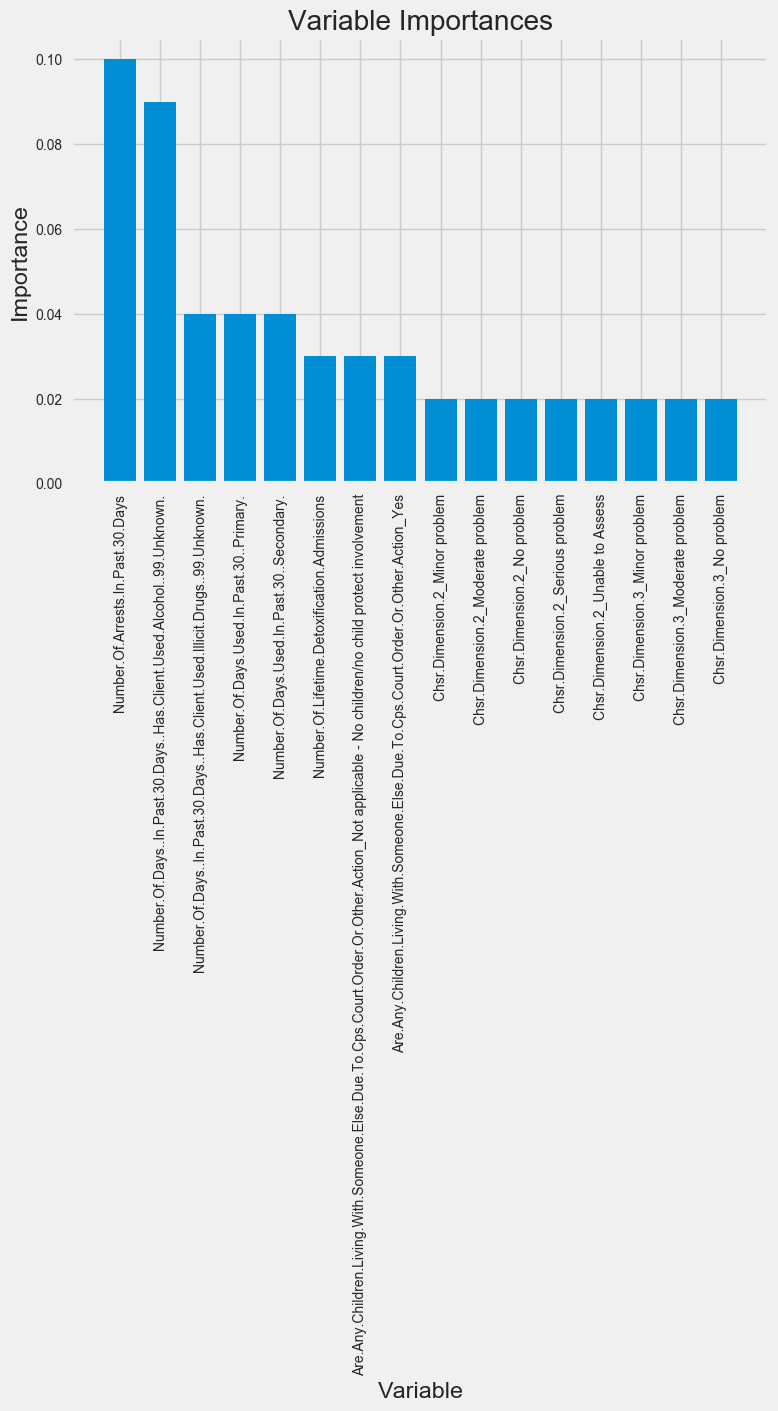

In [396]:
# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(feature_importances.Imp)))

# Make a bar chart
plt.bar(x_values, feature_importances.Imp, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, inputs, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [397]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

y_pred = rf_clf.predict(X_test)
print("Accuracy is ", accuracy_score(y_test,y_pred)*100)

print("Precision, Recall and F-score: \n", precision_recall_fscore_support(y_test, y_pred, average = 'binary'))

Accuracy is  72.6362625139
Precision, Recall and F-score: 
 (0.67839195979899503, 0.69587628865979378, 0.6870229007633587, None)


## Logistic Regression Model

In [400]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(random_state=20, C=0.5)
logistic = logistic.fit(X,y)

In [401]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

y_pred = logistic.predict(X_test)
print("Accuracy is ", accuracy_score(y_test,y_pred)*100)

print("Precision, Recall and F-score: \n", precision_recall_fscore_support(y_test, y_pred, average = 'binary'))

Accuracy is  67.5194660734
Precision, Recall and F-score: 
 (0.61650485436893199, 0.65463917525773196, 0.63500000000000001, None)


In [426]:
from sklearn.feature_selection import f_regression

p_values = f_regression(X,y)
p_values = list(p_values[1])
vals = [(val,feat) for val,feat in zip(p_values,inputs) if val < 0.00001]

vals = sorted(vals, key = lambda x: x[0])

print("P-value\t\t\t\tFeature")
for x in vals:
    print(x[0],"\t", x[1])

P-value				Feature
8.52605784169e-34 	 Race1_African American
3.32582495116e-14 	 Race1_American Indian or Alaska Native
4.35965731325e-13 	 Chsr.Dimension.3_Moderate problem
6.2622089135e-13 	 Tertiary.Substance.Abuse.Problem_Nicotine/Tobacco (May not be primary)
7.40108061987e-11 	 Race1_White
9.61458507344e-11 	 Race1_Black or African American
1.04065382394e-10 	 Chsr.Dimension.2_No problem
4.13672548859e-10 	 Chsr.Dimension.2_Minor problem
1.03071196281e-09 	 Chsr.Dimension.3_Serious problem
2.26204015998e-08 	 Chsr.Dimension.4_No problem
1.7399052028e-07 	 Chsr.Dimension.2_Serious problem
1.67547297696e-06 	 Primary.Substance.Abuse.Problem_Heroin
7.2078303263e-06 	 Chsr.Dimension.6_Moderate problem
9.04875582384e-06 	 Current.Cd.Treatment_Residential, more than 30 days planned
